In [ ]:
!pip install kaggle

In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!kaggle competitions download -c ashrae-energy-prediction


test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
weather_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
building_metadata.csv: Skipping, found more recently modified local copy (use --force to force download)
weather_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
## unzip the data

#!unzip weather_test.csv.zip 
#!unzip test.csv.zip 
!unzip weather_train.csv.zip
!unzip train.csv.zip
#!unzip sample_submission.csv.zip

#commented unzip so would not cause stops during process run

Archive:  weather_test.csv.zip
replace weather_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  weather_train.csv.zip
replace weather_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
## create dataframes
import numpy as np
import pandas as pd
train_df = pd.read_csv('/content/train.csv')
#test_df = pd.read_csv('/content/test.csv')
weather_train_df=pd.read_csv('/content/weather_train.csv')
#weather_test_df=pd.read_csv('/content/weather_test.csv')
build_df=pd.read_csv('/content/building_metadata.csv')

In [ ]:
train_df = pd.read_csv('/content/train.csv')

In [ ]:
##function to reduce mem use
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
##memory use reduction

train_df = reduce_mem_usage(train_df)
#test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
#weather_test_df = reduce_mem_usage(weather_test_df)
builda_df = reduce_mem_usage(build_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


NameError: ignored

In [ ]:
def RMSLE(labels, preds):
  assert len(preds) == len(labels) #checks to make sure both datasets are the same size, can remove later
  return np.sqrt(skmet.mean_squared_log_error(preds,labels,)) #use sklearn metrics MSLE to get MSLE, then take the root of it.

**Remove Nulls From Weather Data**
```



In [ ]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [ ]:
weather_train_df.describe()
# means are Nan because the precision needs to be float64 and not float16

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [ ]:
col=["air_temperature","cloud_coverage", "dew_temperature","precip_depth_1_hr","sea_level_pressure","wind_direction","wind_speed"]

In [ ]:
weather_train_df[col]=weather_train_df[col].astype(np.float64) #changes type to float64 so that this actually runs

In [ ]:
weather_train_df.isnull().sum() #find nulls in weather

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [ ]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
#interpolate using the interpolate

In [ ]:
#impute missing values that the interpolator could not fill in
from sklearn.impute import SimpleImputer
num_columns = ["cloud_coverage",
               "precip_depth_1_hr",
               "sea_level_pressure"]
weather_train_df.loc[:,num_columns]= SimpleImputer().fit_transform(weather_train_df.loc[:,num_columns])

In [ ]:
weather_train_df.isnull().sum() #verify that the Nulls are gone, success!

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

Feat Eng

In [ ]:
# only run once 
# may need to move to the beginning
# weather_train_df_copy = weather_train_df.copy()
#commented out to save RAM

In [ ]:
# Create daily average
def add_daily_avg(weather_train_df):
  weather_train_df['date'] = weather_train_df['timestamp2'].dt.date
  weather_train_df_daily_avg_airtemp = weather_train_df.groupby(['site_id','date'])['air_temperature'].agg(['mean', 'max','min'])
  weather_train_df_daily_avg_airtemp['diff'] = weather_train_df_daily_avg_airtemp['max']-weather_train_df_daily_avg_airtemp['min']
  weather_train_df_daily_avg_airtemp = weather_train_df_daily_avg_airtemp.rename(columns={'mean': 'avg_daily_temp', 'diff': 'diff_daily_temp', 'max': 'max_daily_temp', 'min': 'min_daily_temp'})
  weather_train_df = pd.merge(weather_train_df, weather_train_df_daily_avg_airtemp, how='left', left_on=['site_id','date'], right_on=['site_id','date'])
  #clean the merged dataframe
  weather_train_df = weather_train_df.drop(columns=['timestamp2', 'date'])
  return weather_train_df

In [ ]:
#feature engineering before join
from datetime import datetime

#Create the moving average of last few hours
def add_moving_average(weather_train_df):
  weather_train_df['timestamp2'] = weather_train_df['timestamp'].astype('datetime64[ns]')
  weather_train_df.sort_values(by=['site_id', 'timestamp2'])
  weather_train_df['avg_air_temp_last_5hr'] = weather_train_df.groupby('site_id')['air_temperature'].transform(lambda x: x.rolling(5, 1).mean())
  return weather_train_df

In [ ]:
weather_train_df = add_moving_average(weather_train_df)
weather_train_df = add_daily_avg(weather_train_df)
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,avg_air_temp_last_5hr,avg_daily_temp,max_daily_temp,min_daily_temp,diff_daily_temp
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,25.000000,23.3375,28.3,18.9,9.4
1,0,2016-01-01 01:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5,24.700000,23.3375,28.3,18.9,9.4
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,24.066667,23.3375,28.3,18.9,9.4
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,23.325000,23.3375,28.3,18.9,9.4
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,22.660000,23.3375,28.3,18.9,9.4


In [ ]:
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'], errors='coerce')

In [ ]:
## converting timestamp to day, hour..
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["day"] = df["timestamp"].dt.day
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["date"] = df["timestamp"].dt.date

#commented out because crashing during get_dummies

In [ ]:
preprocess(weather_train_df)

In [ ]:
weather_train_df_grouped = weather_train_df.groupby(["date","site_id"])
df2=weather_train_df_grouped.mean()
df2.head()

air_temperature  cloud_coverage  ...  month  dayofweek
date       site_id                                   ...                  
2016-01-01 0              23.337500        5.333333  ...    1.0        4.0
           1               5.387500        0.000000  ...    1.0        4.0
           2               9.762500        1.000000  ...    1.0        4.0
           3               6.679167        7.583333  ...    1.0        4.0
           4               6.056522        0.956522  ...    1.0        4.0

[5 rows x 16 columns]

Remove Nulls from Bu

In [ ]:
build_df.isnull().sum()
#these columns will be dropped so no need to deal with them

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [ ]:
##Since year_built and floor_count have a lot of Nulls, they are removed from the data
build_df.drop(columns=["year_built","floor_count"],inplace=True)

**Combining the Data**

In [ ]:
#df=train_df.join(build_df.set_index("building_id"), on="building_id")

In [ ]:
train_df=train_df.sample(frac=0.15, replace=False, random_state=1)
train_df.reset_index(drop=True,inplace=True)
train_df.head()

,building_id,meter,timestamp,meter_reading
0,1022,1,2016-09-06 07:00:00,0.00
1,290,0,2016-03-03 21:00:00,65.57
2,667,0,2016-07-26 06:00:00,4.70
3,399,0,2016-06-28 14:00:00,168.71
4,913,0,2016-05-27 19:00:00,1157.00


In [ ]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], errors='coerce')
train_df["date"] = train_df["timestamp"].dt.date

In [ ]:
df=train_df.join(build_df.set_index("building_id"), on="building_id")
df.head()

,building_id,meter,timestamp,meter_reading,date,site_id,primary_use,square_feet
0,1022,1,2016-09-06 07:00:00,0.00,2016-09-06,10,Education,84346
1,290,0,2016-03-03 21:00:00,65.57,2016-03-03,2,Office,51732
2,667,0,2016-07-26 06:00:00,4.70,2016-07-26,5,Entertainment/public assembly,15715
3,399,0,2016-06-28 14:00:00,168.71,2016-06-28,3,Education,180000
4,913,0,2016-05-27 19:00:00,1157.00,2016-05-27,9,Entertainment/public assembly,503634


In [ ]:
df = pd.merge(df, df2,  how='left', on=['site_id','date'])

In [ ]:
df.head()

,building_id,meter,timestamp,meter_reading,date,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,avg_air_temp_last_5hr,avg_daily_temp,max_daily_temp,min_daily_temp,diff_daily_temp,hour,day,month,dayofweek
0,1022,1,2016-09-06 07:00:00,0.00,2016-09-06,10,Education,84346,16.091667,0.000000,0.466667,0.000000,1012.091667,136.666667,2.087500,15.836667,16.091667,23.9,8.3,15.6,11.5,6.0,9.0,1.0
1,290,0,2016-03-03 21:00:00,65.57,2016-03-03,2,Office,51732,23.383333,5.083333,-2.045833,0.000000,1014.120833,103.541667,2.216667,23.373333,23.383333,31.1,16.7,14.4,11.5,3.0,3.0,3.0
2,667,0,2016-07-26 06:00:00,4.70,2016-07-26,5,Entertainment/public assembly,15715,16.333333,0.000000,13.958333,2.581841,1016.137913,271.250000,4.287500,16.108333,16.333333,19.0,13.0,6.0,11.5,26.0,7.0,1.0
3,399,0,2016-06-28 14:00:00,168.71,2016-06-28,3,Education,180000,25.895833,6.500000,22.404167,1.875000,1013.331250,167.500000,3.258333,25.912500,25.895833,30.0,23.3,6.7,11.5,28.0,6.0,1.0
4,913,0,2016-05-27 19:00:00,1157.00,2016-05-27,9,Entertainment/public assembly,503634,21.441667,3.727273,19.625000,5.666667,1007.233333,83.125000,3.162500,21.834167,21.441667,24.4,18.9,5.5,11.5,27.0,5.0,4.0


In [ ]:
df.head()

,building_id,meter,timestamp,meter_reading,date,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,avg_air_temp_last_5hr,avg_daily_temp,max_daily_temp,min_daily_temp,diff_daily_temp,hour,day,month,dayofweek
0,1022,1,2016-09-06 07:00:00,NaN,2016-09-06,10,Education,84346,16.091667,0.000000,0.466667,0.000000,1012.091667,136.666667,2.087500,15.836667,16.091667,23.9,8.3,15.6,11.5,6.0,9.0,1.0
1,290,0,2016-03-03 21:00:00,NaN,2016-03-03,2,Office,51732,23.383333,5.083333,-2.045833,0.000000,1014.120833,103.541667,2.216667,23.373333,23.383333,31.1,16.7,14.4,11.5,3.0,3.0,3.0
2,667,0,2016-07-26 06:00:00,NaN,2016-07-26,5,Entertainment/public assembly,15715,16.333333,0.000000,13.958333,2.581841,1016.137913,271.250000,4.287500,16.108333,16.333333,19.0,13.0,6.0,11.5,26.0,7.0,1.0
3,399,0,2016-06-28 14:00:00,NaN,2016-06-28,3,Education,180000,25.895833,6.500000,22.404167,1.875000,1013.331250,167.500000,3.258333,25.912500,25.895833,30.0,23.3,6.7,11.5,28.0,6.0,1.0
4,913,0,2016-05-27 19:00:00,NaN,2016-05-27,9,Entertainment/public assembly,503634,21.441667,3.727273,19.625000,5.666667,1007.233333,83.125000,3.162500,21.834167,21.441667,24.4,18.9,5.5,11.5,27.0,5.0,4.0


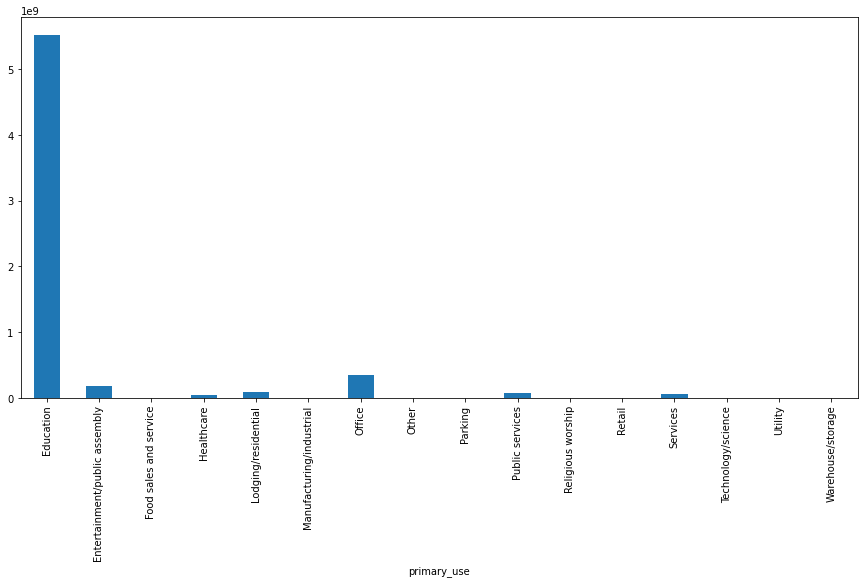

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))


df_plot=df
df_plot.groupby(['primary_use']).sum()['meter_reading'].plot.bar(ax=ax)
plt.show()

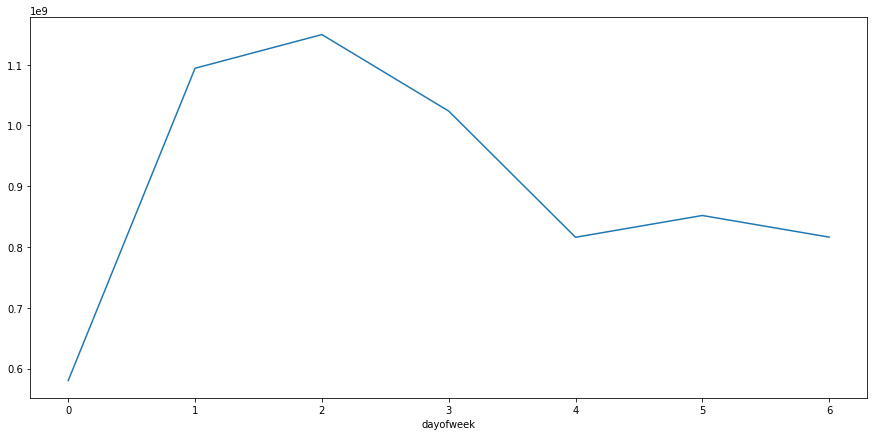

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))


df_plot=df
df_plot.groupby(['dayofweek']).sum()['meter_reading'].plot(ax=ax)
plt.show()

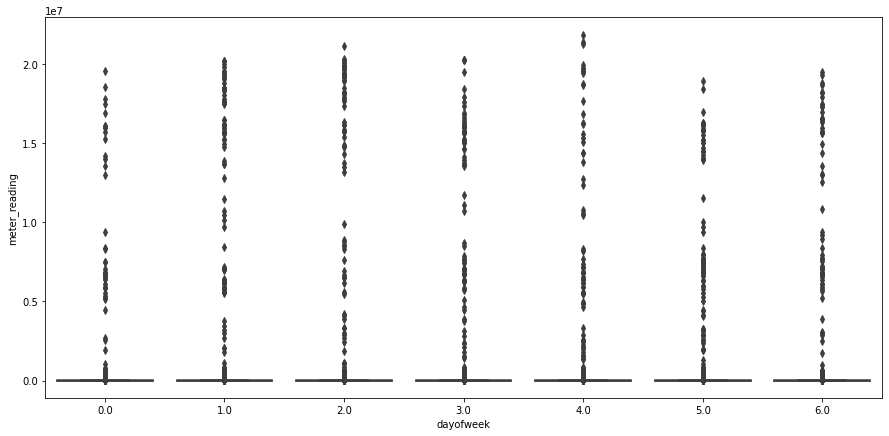

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,7))
df_plot=df
sns.boxplot(x=df_plot["dayofweek"], y=df_plot["meter_reading"])
plt.show()

In [ ]:
df_plot.head()

,building_id,meter,timestamp,meter_reading,date,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,avg_air_temp_last_5hr,avg_daily_temp,max_daily_temp,min_daily_temp,diff_daily_temp,hour,day,month,dayofweek
0,1022,1,2016-09-06 07:00:00,0.00,2016-09-06,10,Education,84346,16.091667,0.000000,0.466667,0.000000,1012.091667,136.666667,2.087500,15.836667,16.091667,23.9,8.3,15.6,11.5,6.0,9.0,1.0
1,290,0,2016-03-03 21:00:00,65.57,2016-03-03,2,Office,51732,23.383333,5.083333,-2.045833,0.000000,1014.120833,103.541667,2.216667,23.373333,23.383333,31.1,16.7,14.4,11.5,3.0,3.0,3.0
2,667,0,2016-07-26 06:00:00,4.70,2016-07-26,5,Entertainment/public assembly,15715,16.333333,0.000000,13.958333,2.581841,1016.137913,271.250000,4.287500,16.108333,16.333333,19.0,13.0,6.0,11.5,26.0,7.0,1.0
3,399,0,2016-06-28 14:00:00,168.71,2016-06-28,3,Education,180000,25.895833,6.500000,22.404167,1.875000,1013.331250,167.500000,3.258333,25.912500,25.895833,30.0,23.3,6.7,11.5,28.0,6.0,1.0
4,913,0,2016-05-27 19:00:00,1157.00,2016-05-27,9,Entertainment/public assembly,503634,21.441667,3.727273,19.625000,5.666667,1007.233333,83.125000,3.162500,21.834167,21.441667,24.4,18.9,5.5,11.5,27.0,5.0,4.0


**Changing the Timestamp**

In [ ]:
df = df.drop(['building_id','site_id',"timestamp"],axis=1) #drop building_id, timestamp, site_id
display(df.head())

,meter,meter_reading,date,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,avg_air_temp_last_5hr,avg_daily_temp,max_daily_temp,min_daily_temp,diff_daily_temp,hour,day,month,dayofweek
0,1,0.000000,2016-09-06,Education,84346,16.091667,0.000000,0.466667,0.000000,1012.091667,136.666667,2.087500,15.836667,16.091667,23.9,8.3,15.6,11.5,6.0,9.0,1.0
1,0,65.570000,2016-03-03,Office,51732,23.383333,5.083333,-2.045833,0.000000,1014.120833,103.541667,2.216667,23.373333,23.383333,31.1,16.7,14.4,11.5,3.0,3.0,3.0
2,0,4.700000,2016-07-26,Entertainment/public assembly,15715,16.333333,0.000000,13.958333,2.581841,1016.137913,271.250000,4.287500,16.108333,16.333333,19.0,13.0,6.0,11.5,26.0,7.0,1.0
3,0,168.710007,2016-06-28,Education,180000,25.895833,6.500000,22.404167,1.875000,1013.331250,167.500000,3.258333,25.912500,25.895833,30.0,23.3,6.7,11.5,28.0,6.0,1.0
4,0,1157.000000,2016-05-27,Entertainment/public assembly,503634,21.441667,3.727273,19.625000,5.666667,1007.233333,83.125000,3.162500,21.834167,21.441667,24.4,18.9,5.5,11.5,27.0,5.0,4.0


In [ ]:
#df.loc[(df['site_id'] == 0) & (df['meter'] == 0), 'meter_reading'] = df[(df['site_id'] == 0) & (df['meter'] == 0)]['meter_reading'] * 0.2931

In [ ]:
df = df.drop(['day'],axis=1)
df = pd.get_dummies(df,columns = ['meter','primary_use',"hour","month","dayofweek"])

In [ ]:
#drop some columns

df.head()

,meter_reading,date,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,avg_air_temp_last_5hr,avg_daily_temp,max_daily_temp,min_daily_temp,diff_daily_temp,meter_0,meter_1,meter_2,meter_3,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,primary_use_Lodging/residential,primary_use_Manufacturing/industrial,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,hour_2.5,hour_8.833333333333334,hour_9.0,hour_9.235294117647058,hour_9.466666666666667,...,hour_12.571428571428571,hour_12.714285714285714,hour_12.833333333333334,hour_12.866666666666667,hour_12.941176470588236,hour_13.0,hour_13.352941176470589,hour_13.5,hour_13.736842105263158,hour_13.777777777777779,hour_14.0,hour_14.25,hour_14.4,hour_14.642857142857142,hour_14.866666666666667,hour_15.125,hour_15.785714285714286,hour_16.615384615384617,hour_16.75,hour_16.76923076923077,hour_21.0,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0,dayofweek_0.0,dayofweek_1.0,dayofweek_2.0,dayofweek_3.0,dayofweek_4.0,dayofweek_5.0,dayofweek_6.0
0,0.000000,2016-09-06,84346,16.091667,0.000000,0.466667,0.000000,1012.091667,136.666667,2.087500,15.836667,16.091667,23.9,8.3,15.6,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,65.570000,2016-03-03,51732,23.383333,5.083333,-2.045833,0.000000,1014.120833,103.541667,2.216667,23.373333,23.383333,31.1,16.7,14.4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,4.700000,2016-07-26,15715,16.333333,0.000000,13.958333,2.581841,1016.137913,271.250000,4.287500,16.108333,16.333333,19.0,13.0,6.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,168.710007,2016-06-28,180000,25.895833,6.500000,22.404167,1.875000,1013.331250,167.500000,3.258333,25.912500,25.895833,30.0,23.3,6.7,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1157.000000,2016-05-27,503634,21.441667,3.727273,19.625000,5.666667,1007.233333,83.125000,3.162500,21.834167,21.441667,24.4,18.9,5.5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
df = df.drop(['date'],axis=1)

**Feature Engineering - Aggreation/Standardization 1 - Test Data**

In [ ]:
# only run once 
# may need to move to the beginning
weather_test_df_copy = weather_test_df.copy()

In [ ]:
# call the definitions of add_moving_average and add_daily_avg
weather_test_df = add_moving_average(weather_test_df_copy)
weather_test_df = add_daily_avg(weather_test_df)
weather_test_df.head()

**Standardization**

In [ ]:
# Standardize the and X columns before modeling

#from sklearn import preprocessing

# standardize the data attributes
#X = df['','']
#standardized_X = preprocessing.scale(X)

Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
import sklearn.metrics as skmet
##set up dataframe for features etc
label_column_name = "meter_reading"
labels = df.loc[:, label_column_name]

##train_test_split to create a training set
x_train, x_test, y_train, y_test = train_test_split(df, labels.values, test_size = 0.2)
tree = RandomForestRegressor(n_estimators=1, max_depth = 3,warm_start=True)
tree = tree.fit(x_train, y_train)
preds = tree.predict(x_test)
RMSLE(y_test, preds)

2.896176164392176

In [ ]:
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import cross_val_score, GridSearchCV

    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0)
    grid_result = gsc.fit(x_train, y_train)
    best_params = grid_result.best_params_
    

KeyboardInterrupt: ignored

In [ ]:
clf=RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)

In [ ]:
 
  ggplot(aes(x= timestamp_day, y= log(meter_reading + 1))) +
  geom_boxplot(alpha = 0.5, fill = "#5EB296", colour = "#4D4D4D") +
  ggtitle("SUNDAYS HAVE THE LOWEST READINGS", subtitle = "Not much difference between the days though") +
  labs(y= "log(Meter Reading)") +
  coord_flip() +
  theme(axis.title.y = element_blank())

ValueError: ignored